In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot 
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
gamma = 1.4     #Гамма, она же каппа
#Различные формулы из гаммы
g_m_1_over_2g = (gamma-1)/2/gamma      #g1
g_p_1_over_2g = (gamma+1)/2/gamma      #g2
g_m_1_over_2g_inv = 1/g_m_1_over_2g    #g3
g_m_1_over_2_inv = 2/(gamma-1)         #g4
g_p_1_over_2_inv = 2/(gamma+1)         #g5
g_m_1_over_g_p_1 = (gamma-1)/(gamma+1) #g6
g_m_1_over_2 = (gamma-1)/2             #g7
g_m_1 = gamma-1  

tol = 1e-8

In [3]:
ax_dict = {'x':1,'y':2}

In [4]:
def init():
    W_u_l = np.array([0.5323, 1.206, 0, 0.3])
    W_u_r = np.array([1.5, 0, 0, 1.5])
    W_d_l = np.array([0.138, 1.206, 1.206, 0.029])
    W_d_r = np.array([0.5323, 0, 1.206, 0.3])
    t = 0.3
    return W_u_l, W_u_r, W_d_l, W_d_r, t

In [5]:
W_u_l, W_u_r, W_d_l, W_d_r, t = init()

In [6]:
def sound_speed(d, p):
    return np.sqrt(gamma * p / d)

In [7]:
def sound_speed_w(W):
    d = W[0]
    p = W[-1]
    return sound_speed(d,p) 

In [8]:
def U_to_W(U):
    W = np.zeros_like(U)
    W[0] = U[0]
    W[1] = U[1]/U[0]
    W[2] = U[2]/U[0]
    W[3] = g_m_1*(U[3] - 0.5*(U[1]**2 + U[2]**2)/U[0])
    return W

In [9]:
def W_to_U(W):
    U = np.zeros_like(W)
    U[0] = W[0]
    U[1] = W[1]*W[0]
    U[2] = W[2]*W[0]
    U[3] = 0.5*(W[1]**2 + W[2]**2)*W[0]+W[3]/g_m_1
    return U

In [10]:
def flux(W, axis):
    F = np.zeros_like(W)
    E = 0.5*(W[1]**2 + W[2]**2)*W[0] + W[3]/g_m_1
    if axis == 'x':
        F[0] = W[1]*W[0]
        F[1] = W[1]**2*W[0] + W[3]
        F[2] = W[1]*W[2]*W[0]
        F[3] = W[1]*(E + W[3])
    elif axis == 'y':
        F[0] = W[2]*W[0]
        F[1] = W[1]*W[2]*W[0]
        F[2] = W[2]**2*W[0] + W[3]
        F[3] = W[2]*(E + W[3])       
    else:
        print('wrong axis_fluxes')
        return -1
    return F

In [11]:
def q(p, p_star):
    if p_star > p:
        return (1 + g_p_1_over_2g * (p_star / p - 1))**0.5
    else :
        return 1

In [12]:
def enthalpy(W):
    return 0.5 * (W[1]**2 + W[2]**2) + gamma / g_m_1 * (W[-1]/W[0])

In [13]:
"""
def get_speeds(W_l,W_r,p_star,axis):
    S_l = W_l[ax_dict[axis]] - sound_speed_w(W_l) * q(W_l[-1], p_star)
    S_r = W_r[ax_dict[axis]] + sound_speed_w(W_r) * q(W_r[-1], p_star)
    
    return np.asarray((S_l,S_r))
"""

'\ndef get_speeds(W_l,W_r,p_star,axis):\n    S_l = W_l[ax_dict[axis]] - sound_speed_w(W_l) * q(W_l[-1], p_star)\n    S_r = W_r[ax_dict[axis]] + sound_speed_w(W_r) * q(W_r[-1], p_star)\n    \n    return np.asarray((S_l,S_r))\n'

In [14]:
def get_speeds(W_l,W_r,p_star, axis):
    S_l = W_l[ax_dict[axis]] - sound_speed_w(W_l)*q(W_l[-1],p_star)
    S_r = W_r[ax_dict[axis]] + sound_speed_w(W_r)*q(W_r[-1],p_star)
    
    S_star = (W_r[-1] - W_l[-1] + \
              W_l[0]*W_l[ax_dict[axis]]*(S_l - W_l[ax_dict[axis]]) - \
              W_r[0]*W_r[ax_dict[axis]]*(S_r - W_r[ax_dict[axis]]))/( W_l[0]*(S_l - W_l[ax_dict[axis]]) - \
              W_r[0]*(S_r - W_r[ax_dict[axis]]) )
    return np.asarray((S_l,S_r,S_star))

In [15]:
def guess_p(W_l, W_r, axis):
    

    c_l = sound_speed(W_l[0],W_l[-1])
    c_r = sound_speed(W_r[0],W_r[-1])
    
    q_temp = 2.0
    
    d_l, u_l, p_l = W_l[0], W_l[ax_dict[axis]], W_l[-1]
    d_r, u_r, p_r = W_r[0], W_r[ax_dict[axis]], W_r[-1]
        
    p_pv = max(0.0, 0.5 * (p_l + p_r) - 0.125 * (u_r - u_l) * (d_l + d_r) * (c_l + c_r))
    p_min = min(p_l, p_r)
    p_max = max(p_l, p_r)
    q_max = p_max / p_min
          
    if q_max <= q_temp and p_min <= p_pv <= p_max:
        p_m = p_pv
    elif p_pv < p_min:
        p_m = ((c_l + c_r - 0.5 * g_m_1 * (u_r - u_l))/(c_l / p_l ** g_m_1_over_2g + c_r / p_r ** g_m_1_over_2g)) ** g_m_1_over_2g_inv
    else:
        g_l = ((g_p_1_over_2_inv / d_l) / (g_m_1_over_g_p_1 * p_l + p_pv)) ** 0.5
        g_r = ((g_p_1_over_2_inv / d_r) / (g_m_1_over_g_p_1 * p_r + p_pv)) ** 0.5
        p_m = (g_l * p_l  + g_r * p_r - (u_r - u_l)) / (g_l + g_r)
        
    return p_m

In [16]:
def F_HLLC(W, S_star, S, axis):
    D = np.asarray([0, 0, 0, S_star])
    D[ax_dict[axis]] = 1
    F_star = (S_star*(S*W_to_U(W) - flux(W,axis)) + \
              S * (W[-1] + W[0]*(S - W[ax_dict[axis]]) * (S_star - W[ax_dict[axis]])) * D) / (S - S_star)
    return F_star

In [17]:
def hllc_flux(W_l, W_r, axis):
    p_star = guess_p(W_l, W_r, axis)
    S_l,S_r,S_star = get_speeds(W_l, W_r, p_star, axis)
    if 0 <= S_l:
        return flux(W_l, axis)
    if S_l <= 0 <= S_star:
        return F_HLLC(W_l,S_star,S_l, axis)
    if S_star <= 0 <= S_r:
        return F_HLLC(W_r,S_star,S_r, axis)
    if 0 >= S_r:
        return flux(W_r, axis)

In [18]:
def hll_flux(W_l, W_r, axis):
    p_star = guess_p(W_l, W_r, axis)
    S_l,S_r = get_speeds(W_l, W_r, p_star, axis)
    if 0 <= S_l:
        return flux(W_l, axis)
    if S_l <= 0 <= S_r:
        return (S_r * flux(W_l, axis) - S_l * flux(W_r, axis) + S_r * S_l * (W_to_U(W_r) - W_to_U(W_l))) / (S_r - S_l)
    if 0 >= S_r:
        return flux(W_r, axis)

In [24]:
N_points = 41
x = np.linspace(0, 1, N_points)
y = np.linspace(0, 1, N_points)
decay_pos = 0.5
W_correct = np.zeros((N_points, N_points, 4))
X, Y = np.meshgrid(x, y) #делаем двумерную сетку: в X х-координаты сетки, в Y y-координаты

In [25]:
dx = 1./(N_points - 1)
dy = 1./(N_points - 1)
sigma = 0.9

W = np.zeros_like(W_correct)
fluxes = np.zeros(((N_points - 1) * (N_points - 1), 4))
U = np.zeros_like(W)

In [26]:
W[(X < decay_pos) * (Y < decay_pos)] = W_d_l
W[(X < decay_pos) * (Y >= decay_pos)] = W_u_l
W[(X >= decay_pos) * (Y < decay_pos)] = W_d_r
W[(X >= decay_pos) * (Y >= decay_pos)] = W_u_r

Text(0, 0.5, 'y')

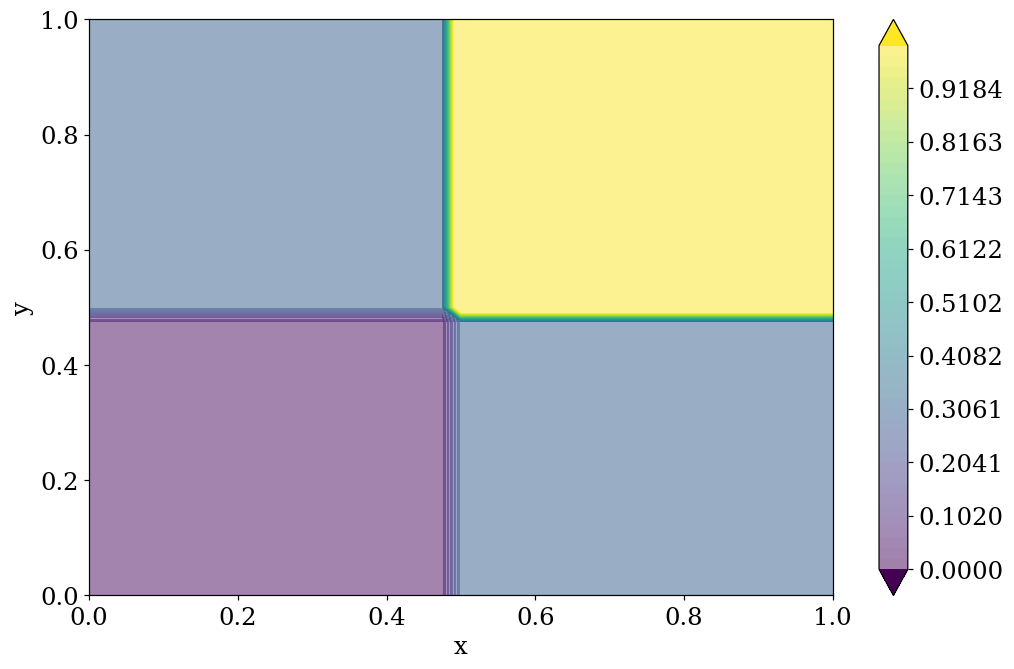

In [27]:
fig = pyplot.figure(figsize = (11, 7), dpi = 109)
pyplot.contourf(X, Y, W[:, :, -1], alpha = 0.5, extend = 'both', levels = np.linspace(0, 1))
pyplot.colorbar()
#pyplot.quiver(X, Y, W[:, :, 1], W[:, :, 2])

pyplot.xlabel('x')
pyplot.ylabel('y')

In [28]:
t_ = 0
U_n = np.copy(U)
while t_ < t:
    U = W_to_U(W.T).T
    hllc_fluxes_f = np.zeros((N_points - 1, N_points - 1, 4))
    hllc_fluxes_g = np.zeros((N_points - 1, N_points - 1, 4))
    speeds = np.zeros((N_points - 1, N_points - 1))
    for i, x_ in enumerate(x[:-1]):
        for j, y_ in enumerate(y[:-1]):
            hllc_fluxes_f[i, j] = hllc_flux(W[i, j], W[i + 1, j], 'x')
            hllc_fluxes_g[i, j] = hllc_flux(W[i, j], W[i, j + 1], 'y')
            c_l = sound_speed_w(W[i, j])
            c_r = sound_speed_w(W[i + 1, j])
            c_u = sound_speed_w(W[i, j + 1])
            speeds[i, j] = max(abs(W[i, j][1] + c_l), abs(W[i + 1, j][1] + c_r),
                               abs(W[i, j + 1][2] + c_u), abs(W[i, j][2] + c_l))
            
    dt = sigma * dx / np.max(speeds) / 2.
    U_n[1:-1, 1:-1, :] = U[1:-1, 1:-1, :] + dt / dx * (hllc_fluxes_f[:-1, 1:, :] - hllc_fluxes_f[1:, 1:, :]) + dt / dy * (hllc_fluxes_g[1:, :-1, :] - hllc_fluxes_g[1:, 1:, :])
    U_n[0, :, :] = U_n[1, :, :]
    U_n[-1, :, :] = U_n[-2, :, :]
    U_n[:, 0, :] = U_n[:, 1, :]
    U_n[:, -1, :] = U_n[:, -2, :]
    W = U_to_W(U_n.T).T
    t_ += dt

Text(0, 0.5, 'y')

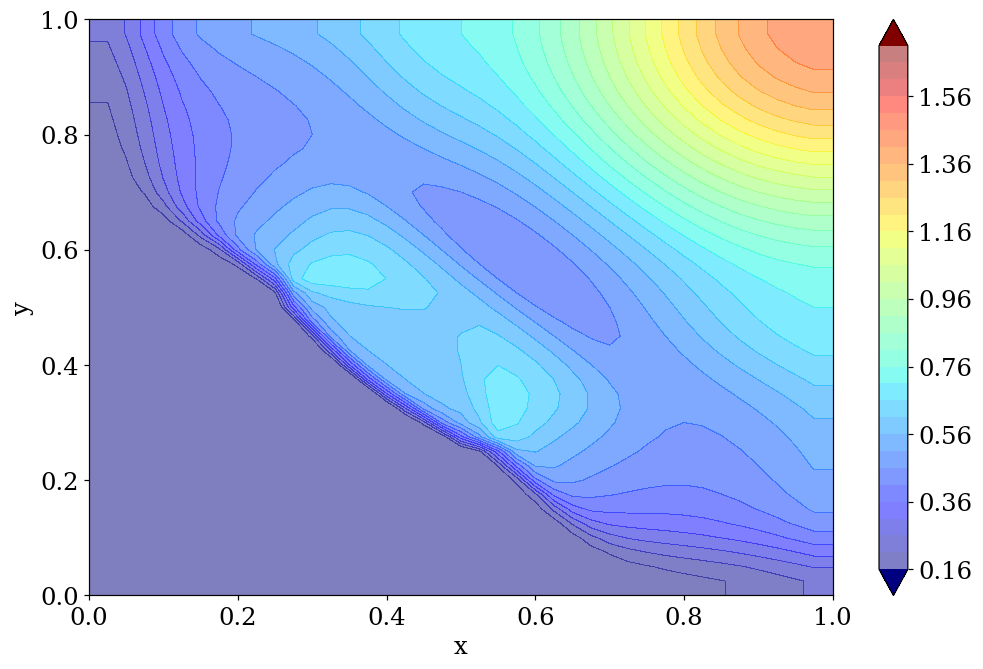

In [29]:
fig = pyplot.figure(figsize = (11, 7), dpi = 109)
pyplot.contourf(X, Y, W[:, :, -1], alpha = 0.5, extend = 'both', levels = np.linspace(0.16, 1.71, 32), cmap = 'jet')
pyplot.colorbar()
#pyplot.quiver(X, Y, W[:, :, 1], W[:, :, 2])

pyplot.xlabel('x')
pyplot.ylabel('y')